In [1]:
"""
Philosophy of this network:
    The goal that I had while writing this was for me to cement my understanding of the basic fully connected feed-forward network.
    My original implementation was quite slow, as it was not taking advantage of numpy vectorization - this version does. You can compare
    the previous version of this file to this one (filename nn.py, commit 9cb3da3ce582e940ed862f95930879c8be1721d1), and see the 
    significant training speed differences. I will say, adding vectorization makes the code less readable (and also increases the
    required memory) as I had to pad all vectors and matricies with zeros so each set of data had the same shape (and therefore it could be vectorized).
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from loss_fcns import squared_loss, cross_entropy_loss
from activations import eLU, ReLU, leaky_ReLU, sigmoid, linear, tanh, softmax


np.set_printoptions(suppress=True)
np.random.seed(1337)


In [2]:
def greater_than_9():
    def _get_one_hot(targets, num_classes):
        """
        targets (num_samples,)
        output  (num_classes, num_samples)
        """
        ret = np.zeros((num_classes, targets.shape[0]))
        ret[targets, np.arange(targets.size)] = 1
        return ret

    return (
        np.load("fake_data/X_train.npy"),
        _get_one_hot(np.load("fake_data/Y_train.npy"), 2),
        np.load("fake_data/X_test.npy"),
        _get_one_hot(np.load("fake_data/Y_test.npy"), 2),
    )


def mnist():
    def _get_one_hot(targets, num_classes):
        """
        targets (num_samples,)
        output  (num_classes, num_samples)
        """
        ret = np.zeros((num_classes, targets.shape[0]))
        ret[targets, np.arange(targets.size)] = 1
        return ret

    def load_data(fname):
        data_folder = "mnist_data/"
        with open(data_folder + fname, "rb") as f:
            data = f.read()
        return np.frombuffer(data, dtype=np.uint8)

    x_train = load_data("train-images-idx3-ubyte")
    y_train = load_data("train-labels-idx1-ubyte")
    x_test = load_data("t10k-images-idx3-ubyte")
    y_test = load_data("t10k-labels-idx1-ubyte")

    return (
        x_train[16:].reshape((28 * 28, -1), order="C"),
        _get_one_hot(y_train[8:], 10).reshape((10, -1)),
        x_test[16:].reshape((28 * 28, -1), order="C"),
        _get_one_hot(y_test[8:], 10).reshape((10, -1)),
    )

X_train, Y_train, X_test, Y_test = greater_than_9()
print("data loaded")

# net = ffnn.FFNN([784, 512, 128, 10], [tanh, tanh, softmax], cross_entropy_loss)
layers = [2, 2, 2]
hs = [ReLU, softmax]
cost_fcn = cross_entropy_loss

data loaded


In [3]:
def make_network(random=True):
    """
    random == False for generating empty weight/bias matricies
    """
    layer_arr = layers

    weights = []
    biases = []

    layer_iter = iter(layer_arr)
    prev_dim = layer_iter.__next__()

    for i, dim in enumerate(layer_iter):
        if random:
            bound = np.sqrt(2 / layer_arr[i])
            weight_matrix = np.random.uniform(low=-bound, high=bound, size=(dim, prev_dim)).astype(np.float32)
            biases_matrix = np.random.uniform(low=-bound, high=bound, size=(dim, 1)).astype(np.float32)
        else:
            weight_matrix = np.zeros((dim, prev_dim), dtype=np.float32)
            biases_matrix = np.zeros((dim, 1), dtype=np.float32)

        weights.append(weight_matrix)
        biases.append(biases_matrix)
        prev_dim = dim

    return weights, biases

weights, biases = make_network()

In [4]:
def feed_forward(xs, training=False):
    """
    Feed-forward through the network, saving the activations and non-linearities
    after each layer for backprop.

    xs has to be of shape (num features, batch_size)
    - x, z, a are all vectors of inputs, outputs, and linear outputs at layers
    """
    zs = []
    activations = []

    activation = xs.astype(np.float32) / 255
    activations.append(activation)
    for i, (W, b) in enumerate(zip(weights, biases)):
        z = np.einsum("ij, jb -> ib", W, activation) + b
        zs.append(z)
        activation = hs[i].f(z)
        activations.append(activation)

    return (activation, activations, zs) if training else activation

d1 = np.asarray([[1],[1]])
print(d1.shape, feed_forward(d1).sum())

d2 = np.asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],[9,8,7,6,5,4,3,2,1,0]])
print(d2.shape, feed_forward(d2).sum())

print(X_train[:,:10].shape, feed_forward(X_train[:,:10]).sum())


(2, 1) 1.0
(2, 10) 10.0
(2, 10) 10.000001


In [5]:
def back_prop(xs, ts):
    """
    xs,ts are lists of vectors (ts are targets for training i.e. true output given input x)
    """
    weight_grads, bias_grads = make_network(random=False)
    ys, activations, zs = feed_forward(xs, training=True)

    # delta_L = grad cost_fcn(outputs) * activation_fcn.deriv(weighted_output_last_layer)
    # should be hadamard product
    # Also, ys is just activations[-1]
    assert ts.shape == ys.shape

    delta = cost_fcn.deriv(ts, ys) * hs[-1].deriv(zs[-1])
    batch_weights = np.einsum("ib, jb -> ijb", delta, activations[-2])

    # sum along batch
    bias_grads[-1][:, :] = np.mean(delta, axis=-1).reshape(-1, 1)
    weight_grads[-1][:, :] = np.mean(batch_weights, axis=-1)

    # back propogate through layers
    for l in range(2, len(layers)):
        nonlinear_deriv = hs[-l].deriv(zs[-l])
        delta = np.dot(weights[-l + 1].T, delta) * nonlinear_deriv
        batch_weights = np.einsum("ib, jb -> ijb", delta, activations[-l - 1])

        bias_grads[-l][:, :] = np.mean(delta, axis=-1).reshape(-1, 1)
        weight_grads[-l][:, :] = np.mean(batch_weights, axis=-1)

    for new_b, new_g, self_b, self_g in zip(bias_grads, weight_grads, biases, weights):
        assert new_b.shape == self_b.shape
        assert new_g.shape == self_g.shape

    return weight_grads, bias_grads

m = 1
n = 10
back_prop(X_train[:,m:m+n], Y_train[:,m:m+n]), X_train[:,m:m+n], Y_train[:,m:m+n]
X_train[:,m:m+1], feed_forward(X_train[:,m:m+1])

(array([[9],
        [3]]),
 array([[0.38942432],
        [0.6105757 ]], dtype=float32))

In [6]:
def mini_batch(batch_xs, batch_ys, lr):
    """
    batch_xs is the batch of inputs, batch_ys is batch of outputs, lr is learning rate
    """
    global weights, biases
    weight_grads, bias_grads = back_prop(batch_xs, batch_ys)

    weights = [
        w - lr * weight_grad for w, weight_grad in zip(weights, weight_grads)
    ]
    biases = [b - lr * bias_grad for b, bias_grad in zip(biases, bias_grads)]


In [7]:
def learn(xs, ys, epochs, batch_size, lr):
    """
    xs/ys is the input/output data, epochs is
    the number of batches to train, batch size is the number of input/outputs to
    use in each batch, and lr is learning rate.

    xs, ys have the input vectors as COLUMNS, so xs shape should be (num_features, batch_size)
    e.g. with MNIST, each image is 28*28=784 features, so xs is (784, 60000)
    since there are 10 classes in mnist, y should be (10, 60000)
    """
    losses = []
    accuracies = []
    # get random indicies from batch
    random_indicies = np.random.choice(xs.shape[1], size=batch_size)
    for epoch in range(epochs):
        mini_batch(xs[:, random_indicies], ys[:, random_indicies], lr)

        ts = ys[:, random_indicies]
        ys_out_test = feed_forward(xs[:, random_indicies])

        loss = cost_fcn.f(ts, ys_out_test)
        train_loss = np.mean(loss)

        losses.append(train_loss)
        accuracies.append(np.sum(np.argmax(ts, axis=0) == np.argmax(ys_out_test, axis=0)) / ts.shape[-1])

        if epoch % 50 == 0:
            print(f"epoch {epoch} \t train loss {train_loss:.8f}")

    return losses, accuracies


In [14]:
losses, accuracies = learn(X_train, Y_train, 1000, 128, 1)

epoch 0 	 train loss 0.62109479
epoch 50 	 train loss 0.63593870
epoch 100 	 train loss 0.63679791
epoch 150 	 train loss 0.63535124
epoch 200 	 train loss 0.63270107
epoch 250 	 train loss 0.62969927
epoch 300 	 train loss 0.62661826
epoch 350 	 train loss 0.62354325
epoch 400 	 train loss 0.62049931
epoch 450 	 train loss 0.61749308
epoch 500 	 train loss 0.61452435
epoch 550 	 train loss 0.61159195
epoch 600 	 train loss 0.60869382
epoch 650 	 train loss 0.60582828
epoch 700 	 train loss 0.60299352
epoch 750 	 train loss 0.60018831
epoch 800 	 train loss 0.59741076
epoch 850 	 train loss 0.59465972
epoch 900 	 train loss 0.59221759
epoch 950 	 train loss 0.58907631


Test loss: 0.606
Test accuracy: 1.000


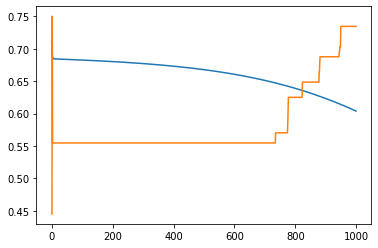

In [9]:
np.save("weights.npy", np.asarray(weights, dtype=object))
np.save("biases.npy", np.asarray(biases, dtype=object))

test_out = feed_forward(X_test)
test_argmax = np.argmax(test_out, axis=0)
Y_test_argmax = np.argmax(Y_test, axis=0)

test_losses = cross_entropy_loss.f(Y_test, test_out)
print("Test loss: {:.3f}".format(np.mean(test_losses)))
print("Test accuracy: {:.3f}".format(np.sum(Y_test == test_argmax) / Y_test.shape[1]))

samp_loss = sorted(zip(X_test.T, test_losses), key=lambda v: v[1])

plt.plot(range(len(losses)), losses)
plt.plot(range(len(accuracies)), accuracies)
plt.show()


In [13]:
test_out = feed_forward(X_test)
test_argmax = np.argmax(test_out, axis=0)
Y_test_argmax = np.argmax(Y_test, axis=0)

test_losses = cross_entropy_loss.f(Y_test, test_out)
print("Test loss: {:.3f}".format(np.mean(test_losses)))
print("Test accuracy: {}".format(np.sum(Y_test_argmax == test_argmax) / Y_test.shape[1]))

samp_loss = sorted(zip(X_test.T, test_losses), key=lambda v: v[1])
(test_argmax == Y_test_argmax).sum() / Y_test.shape[1]

Test loss: 0.606
Test accuracy: 0.757


0.757